In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import mlflow
import mlflow.sklearn

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df = pd.read_csv("completed_Apples_stock price dataset.csv" )
df.shape

(50592, 12)

In [4]:
import json
try:
    with open("model_scores.json", "r") as f:
            final_scores = json.load(f)
except FileNotFoundError: 
    final_scores = {}   # start fresh if file doesn't exist

In [5]:
# Prophet requires columns: 'ds' (date/time) and 'y' (target)
df['ds'] = pd.to_datetime(df['date'] + " " + df['time'])
df['y'] = df['stock_price']

In [6]:
# Select exogenous variables 
# exog_vars = ["nasdaq_index", "sp500_index", "inflation_rate","unemployment_rate", "interest_rate", "market_sentiment"]

exog_vars = ["nasdaq_index",  "market_sentiment"]

In [7]:
# Initialize Prophet model and add regressors 
model = Prophet()
for var in exog_vars:
    model.add_regressor(var)

In [8]:
# Fit model 
model.fit(df[['ds','y'] + exog_vars])

08:48:21 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Create future dataframe 
future = model.make_future_dataframe(periods=730)  # forecast 730 days ahead

In [10]:
# Historical exog (same length as your original df)
historical_exog = df[exog_vars].reset_index(drop=True)

# Future exog (repeat last row for forecast horizon)
last_row = df[exog_vars].iloc[-1]
future_exog = pd.DataFrame([last_row.values] * 730, columns=exog_vars)

# Combine historical + future exog
all_exog = pd.concat([historical_exog, future_exog], axis=0).reset_index(drop=True)

# Align with future dataframe
future = future.reset_index(drop=True)
future = pd.concat([future, all_exog], axis=1)

In [11]:
# Forecast 
forecast = model.predict(future)

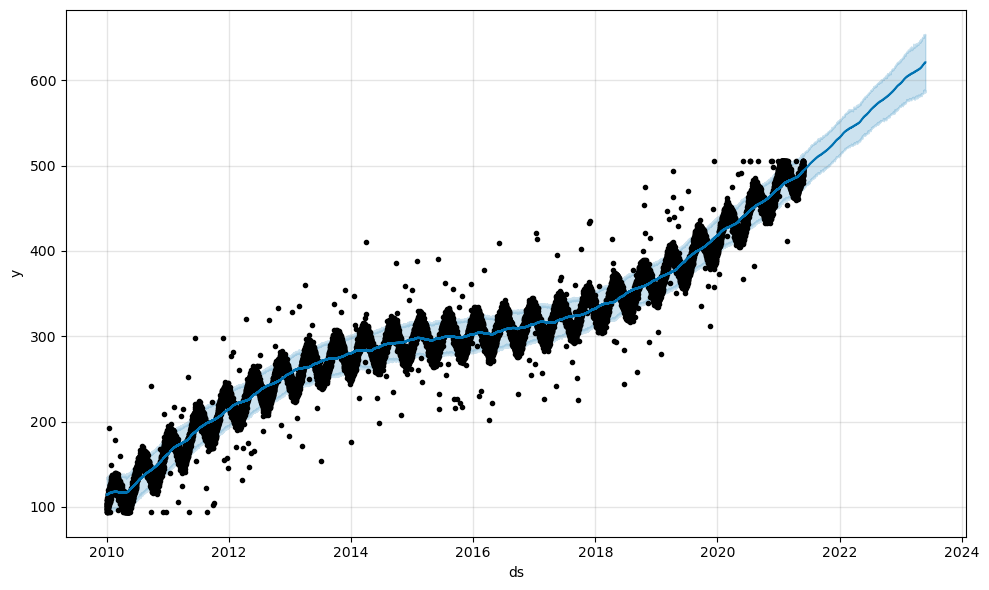

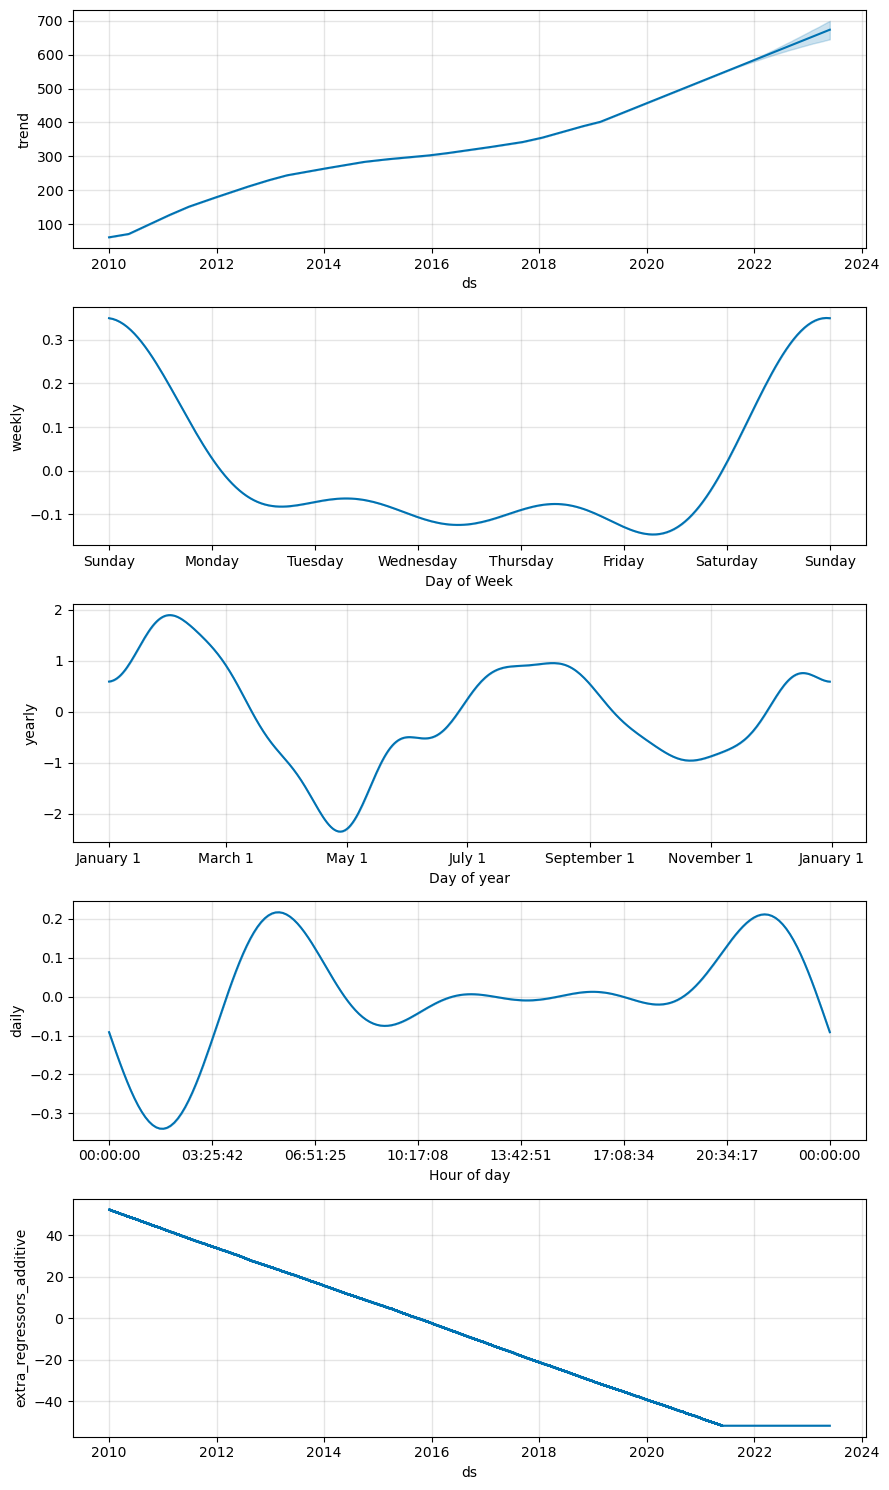

In [12]:
#  Plot results 
fig1 = model.plot(forecast)
plt.savefig("prophet")
model.plot_components(forecast)
plt.savefig("prophet_componenets")
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Actual vs predicted (on historical data)
y_true = df['y']
y_pred = forecast.loc[:len(df)-1, 'yhat']  # only compare historical part

# RMSE
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
# MAE
MAE = mean_absolute_error(y_true, y_pred)
# R²
r2 = r2_score(y_true, y_pred)

print("RMSE:", RMSE)
print("R²:", r2)
print("MAE:", MAE)
final_scores["Prophet"] = {"AIC": "-", "RMSE": RMSE, "R2": r2, "MAE": MAE }

RMSE: 15.3615425761194
R²: 0.9717620406000385
MAE: 13.113925064318444


In [14]:
with mlflow.start_run(run_name=f"Prophet"):    
    mlflow.log_metric("RMSE", float(RMSE))
    mlflow.log_metric("r2Square", float(r2))
    mlflow.log_artifact(f"prophet.png") 
    mlflow.log_artifact(f"prophet_componenets.png") 
    mlflow.sklearn.log_model(model, name="Prophet")

2026/01/31 08:50:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/31 08:50:10 INFO mlflow.store.db.utils: Updating database tables
2026/01/31 08:50:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 08:50:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 08:50:11 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 08:50:11 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 08:50:11 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or 

In [15]:
import json

# Save model score
with open("model_scores.json", "w") as f:
    json.dump(final_scores, f, indent=4)